# Лабораторная работа по курсу "Глубокое обучение"  

## Постановка задачи  

В процессе выполнения работы должны быть решены следующие задачи:

1. Изучение общей схемы метода обратного распространения ошибки на базе стохастического градиентного спуска.
2. Вывод математических формул для вычисления градиентов функции ошибки по параметрам нейронной сети и формул коррекции весов.
3. Проектирование и разработка программной реализации метода обратного распространения ошибки.
4. Тестирование разработанной программной реализации.
5. Разработка примера использования метода обратного распространения ошибки для классификации рукописных цифр из набора данных MNIST [http://yann.lecun.com/exdb/mnist].

Импортирование необходимых библиотек и инициализация константных параметров:

In [64]:
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.utils import np_utils
import numpy as np
import time


W = 28
H = 28
K = 10

Загрузка датасета и его преподготовка: 

Number of train samples: 60000
Number of test samples: 10000


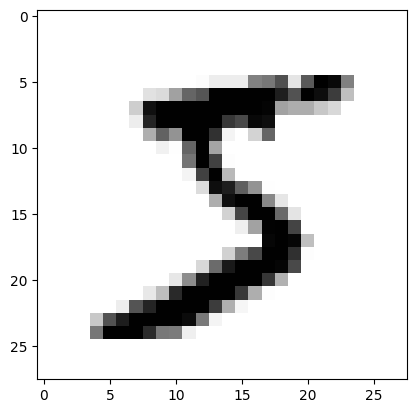

In [65]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

fig = plt.figure()
plt.imshow(X_train[0], cmap = 'binary')

X_train = X_train.reshape(X_train.shape[0], W * H).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], W * H).astype('float32') / 255

y_train = np_utils.to_categorical(y_train, K)
y_test = np_utils.to_categorical(y_test, K)

print('Number of train samples: {}'.format(len(X_train)))
print('Number of test samples: {}'.format(len(X_test)))

Определим функции ReLU, Softmax и кросс-энтропии:

In [66]:
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x)
    return np.exp(x) / np.sum(np.exp(x), axis = 1, keepdims = True)

def CrossEntropyLoss(y, u):
    return np.mean(-np.sum(y * np.log(u), axis = 1))


Определим класс, реализующий:  

1. Топологию нейронной сети
2. Метод обратного распространения ошибки
3. Интерфейс для тренировки полученной топологии

In [67]:
class CustomNN:
    def __init__(self, hidden_layer: int, lr: float, bs: int):
        self.lr = lr
        self.bs = bs
        
        # learnable parameters initialization
        self.weights1 = np.random.randn(W * H, hidden_layer) * 0.01
        self.biases1 = np.zeros((1, hidden_layer))
        self.weights2 = np.random.randn(hidden_layer, K) * 0.01
        self.biases2 = np.zeros((1, K))

    def forward(self, x):
        self.fc1 = np.matmul(x, self.weights1) + self.biases1
        self.relu = relu(self.fc1)
        self.fc2 = np.matmul(self.relu, self.weights2) + self.biases2
        self.softmax = softmax(self.fc2)
    
    def backward(self, x, y):
        dv2 = (self.softmax - y) / self.bs
        grad_W2 = (self.relu.T).dot(dv2)
        grad_b2 = np.sum(dv2, axis = 0, keepdims = True)
        
        dv1 = dv2.dot(self.weights2.T) * np.where(self.fc1 > 0, 1, 0)
        grad_W1 = np.dot(x.T, dv1)
        grad_b1 = np.sum(dv1, axis = 0, keepdims = True)

        self.weights2 -= self.lr * grad_W2
        self.biases2 -= self.lr * grad_b2
        self.weights1 -= self.lr * grad_W1
        self.biases1 -= self.lr * grad_b1
    
    
    def train(self, x, y, epochs):
        start = time.time()
        for epoch in range(epochs):
            start_epoch = time.time()

            for i in range(0, len(x), self.bs):
                x_curr = x[i : i + self.bs]
                y_curr = y[i : i + self.bs]
                self.forward(x_curr)
                self.backward(x_curr, y_curr)

            self.forward(x)
            loss = CrossEntropyLoss(y, self.softmax)
            accuracy = np.mean(np.argmax(self.softmax, axis = 1) == np.argmax(y, axis = 1))
            epoch_time = time.time() - start_epoch
            
            print("Epoch № {}".format(epoch))
            print("\tError: {:.3f}\tAccuracy: {:.3f}\tTime: {:.3f}".format(loss, accuracy, epoch_time))
        total_time = time.time() - start
        print("Total time: {}".format(total_time))
    
    
    def test(self, x, y):
        self.forward(x)
        accuracy = np.mean(np.argmax(self.softmax, axis = 1) == np.argmax(y, axis = 1))
        print("Test accuracy: {}".format(accuracy))

In [68]:
network = CustomNN(300, 0.1, 8)
network.train(X_train, y_train, 20)


Epoch № 0
	Error: 0.121	Accuracy: 0.962	Time: 16.503
Epoch № 1
	Error: 0.075	Accuracy: 0.976	Time: 16.177
Epoch № 2
	Error: 0.050	Accuracy: 0.983	Time: 16.061
Epoch № 3
	Error: 0.039	Accuracy: 0.987	Time: 16.026
Epoch № 4
	Error: 0.033	Accuracy: 0.989	Time: 15.932
Epoch № 5
	Error: 0.029	Accuracy: 0.991	Time: 15.874
Epoch № 6
	Error: 0.023	Accuracy: 0.992	Time: 15.901
Epoch № 7
	Error: 0.023	Accuracy: 0.992	Time: 15.941
Epoch № 8
	Error: 0.015	Accuracy: 0.995	Time: 15.889
Epoch № 9
	Error: 0.012	Accuracy: 0.996	Time: 15.948
Epoch № 10
	Error: 0.007	Accuracy: 0.998	Time: 15.943
Epoch № 11
	Error: 0.003	Accuracy: 0.999	Time: 15.952
Epoch № 12
	Error: 0.002	Accuracy: 1.000	Time: 15.948
Epoch № 13
	Error: 0.002	Accuracy: 1.000	Time: 15.993
Epoch № 14
	Error: 0.001	Accuracy: 1.000	Time: 15.984
Epoch № 15
	Error: 0.001	Accuracy: 1.000	Time: 15.953
Epoch № 16
	Error: 0.001	Accuracy: 1.000	Time: 15.964
Epoch № 17
	Error: 0.001	Accuracy: 1.000	Time: 16.022
Epoch № 18
	Error: 0.001	Accuracy: 1.0

In [69]:
network.test(X_test, y_test)

Test accuracy: 0.9836
